# **Imports**

In [ ]:
from collections import Counter
import random
import re #Regex
from matplotlib import pyplot as plt
from sklearn import metrics #AUC
import pandas as pd #Sólo para visualizar rápidamente diccionarios ( lo dicta el sentido común :-) )

# **EJ 1**

# **Carga de datos**

In [ ]:
def read_file_into_dict(file_name):
  data_set = dict()
  with open(file_name) as f:
    var_names = read_variable_names(f.readline())
    set_variable_names(data_set, var_names)
    read_data(var_names, data_set, f)
  return data_set

def read_variable_names(line):
  names = [name.strip() for name in line.split(',')]
  return names

def set_variable_names(data_set, names):
  for name in names:
    data_set[name] = []

def read_data(var_names, data_set, f, datapoint_names=False):
  line = f.readline()
  datapoint_number = 0
  while line != '' and line != '\n':
    data = [x.strip() for x in line.split(',')]
    for i, var_name in enumerate(var_names):
      if datapoint_names:
        data_set[var_name].append(data[i+1])
      else:
        data_set[var_name].append(data[i])
    line = f.readline()
  return 

Cargamos el dataset y lo visualizamos en un dataframe de pandas

In [ ]:
data_set = read_file_into_dict("PreferenciasBritanicos.csv")
pd.DataFrame.from_dict(data_set)

,scones,cerveza,wiskey,avena,futbol,Nacionalidad
0,0,0,1,1,1,I
1,1,0,1,1,0,I
2,1,1,0,0,1,I
3,1,1,0,0,0,I
4,0,1,0,0,1,I
5,0,0,0,1,0,I
6,1,0,0,1,1,E
7,1,1,0,0,1,E
8,1,1,1,1,0,E
9,1,1,0,1,0,E


# **Naive Bayes**

Primero definimos unas funciones útiles para el algoritmo de Naive Bayes
1. **get_class_probabilities** calcula las probabilidades de cada clase en el dataset
2. **likelihood** (junto con **attribute_likelihood**) calculan las probabilidades de observar los atributos (o no observarlos) dada la clase

Al final visualizamos estas probabilidades. Se observa aplicada la **corrección de Laplace**, dado que todos los escoceses gustan de los scones.

In [ ]:
#Función para calcular la probabilidad de cada clase
def get_class_probabilities(data_set, classes_key):
  ret = {}
  class_names = set(data_set[classes_key])
  for class_name in class_names:
    ret[class_name] = (1+len(list(filter(lambda x : x == class_name, data_set[classes_key]))))/(len(data_set[classes_key]) + len(Counter(data_set[classes_key]).keys()))
  return ret

In [ ]:
#Función para calcular la probabilidad de un atributo dada la clase
def attribute_likelihood(value, key, class_name, class_key, data_set):
    accum = 0
    denom = 0
    for i in range(len(data_set[class_key])):
        if data_set[class_key][i] == class_name:
            denom += 1
            if int(data_set[key][i]) == value:
                accum += 1
    return (accum+1)/(denom+2)

#Función para calcular las probabilidades de los atributos dadas las clases
def likelihood(data_set, class_key):
    likelihood_dict = {}
    for class_name in Counter(data_set[class_key]).keys():
        likelihood_dict[class_name] = {}
        for key in filter(lambda x : x != class_key, data_set.keys()):
            likelihood_dict[class_name][key] = []
            likelihood_dict[class_name][key].append(attribute_likelihood(0, key, class_name, class_key, data_set))
            likelihood_dict[class_name][key].append(1 - likelihood_dict[class_name][key][0])
    return likelihood_dict

likelihood_dict = likelihood(data_set, 'Nacionalidad')
pd.DataFrame.from_dict(likelihood_dict)

,I,E
scones,"[0.5, 0.5]","[0.1111111111111111, 0.8888888888888888]"
cerveza,"[0.5, 0.5]","[0.4444444444444444, 0.5555555555555556]"
wiskey,"[0.625, 0.375]","[0.5555555555555556, 0.4444444444444444]"
avena,"[0.5, 0.5]","[0.3333333333333333, 0.6666666666666667]"
futbol,"[0.5, 0.5]","[0.5555555555555556, 0.4444444444444444]"


La función **naive_bayes** recibe las probabilidades de cada clase, el diccionario devuelto por **likelihood** y una observación nueva y devuelve un diccionario con las probabilidades condicionales de cada categoría.

In [ ]:
def attribute_likelihood_from_dict(likelihood_dict, attribute, value, class_name):
    return likelihood_dict[class_name][attribute][value]

def naive_bayes(class_probabilities, likelihood_dict, evidence_dict):
    ret = {}
    evidence_probability = 0
    for class_name in class_probabilities.keys():
        probability = 1
        for attribute in evidence_dict.keys():
            probability = probability * attribute_likelihood_from_dict(likelihood_dict, attribute, evidence_dict[attribute], class_name)
        evidence_probability += probability * class_probabilities[class_name]
        ret[class_name] = probability * class_probabilities[class_name]
    for class_name in ret.keys():
        ret[class_name] = ret[class_name] / evidence_probability
    return ret

sujeto = {
    'scones': 1,
    'cerveza': 0,
    'wiskey': 1,
    'avena': 1,
    'futbol': 0
}
naive_bayes(get_class_probabilities(data_set, 'Nacionalidad'), likelihood_dict, sujeto)

{'I': 0.23974935950716417, 'E': 0.7602506404928359}

# EJ 2

In [ ]:
def read_titles_and_classes(filename):
    f = open(filename)
    line = f.readline()
    line = f.readline()
    titles, classes = [], []
    while line != '' and line != '\n':
        data = line.split(',')
        titles.append(''.join(data[0:len(data)-1]).strip())
        classes.append(data[-1].strip())
        line = f.readline()
    f.close()
    return titles, classes

def strip_word(word):
    return re.compile('[^a-zA-Záéíóú ]').sub('', word)

La función **get_data_set** recibe una lista de títulos y la lista de clases correspondientes y los transforma en un diccionario de datos, similar al ejercicio 1. Los atributos son las palabras que aparecen a lo largo de los títulos.

In [ ]:
#Función para dividir aleatoriamente un conjunto de índices 0,...,num_items - 1
def divide_random(percentage, num_items):
    a = list(range(num_items))
    random.shuffle(a)
    b1 = a[0:int(num_items*percentage)]
    b2 = a[int(num_items*percentage):num_items]
    return b1,b2    

def divide_test_train(points, classes, percentage, num_points):
    train_indices, test_indices = divide_random(percentage, num_points)
    train_points, test_points = [], []
    train_classes, test_classes = [], []
    for i in train_indices:
        train_points.append(points[i])
        train_classes.append(classes[i])
    for i in test_indices:
        test_points.append(points[i])
        test_classes.append(classes[i])
    return train_points, train_classes, test_points, test_classes

def get_data_set(titles, classes):
    ret = {}
    ret['clase'] = []
    #Obtengo las palabras
    for title in titles:
        words = title.split(' ')
        for word in words:
            w = strip_word(word)
            if not w.isnumeric() and w not in ret.keys() and w != '' and w != " ":
                ret[w] = []
    #Por cada palabra, registro qué títulos la contienen
    i = 0
    for word in filter(lambda x : x != titles and x != 'clase', ret.keys()):
        for title in titles:
            if word in re.compile('[^a-zA-Záéíóú ]').sub('', title).split(' '):
                ret[word].append(1)
            else:
                ret[word].append(0)
    for class_name in classes:
        ret['clase'].append(class_name)
    return ret

def get_max_class(result):
    max_class = ''
    for class_name in result.keys():
        if max_class == '' or result[max_class] < result[class_name]:
            max_class = class_name
    return max_class

def title_to_datapoint(data_set, classes_key, title):
    ret = {}
    words = [w.strip() for w in title.split(' ')]
    for w in filter(lambda x : x != classes_key, data_set.keys()):
        ret[w] = 1 if w in words else 0
    return ret

Leemos los títulos y sus clases, pero solo usamos un subconjunto aleatorio para el entrenamiento del algoritmo. Se podría variar el porcentaje. Al final probamos las funciones recién definidas y usamos las ya definidas para ver cuál es la probabilidad de que un título de deportes tenga la palabra 'messi' y la probabilidad de que un título de economia tenga la palabra 'messi'. Esperamos que la primera sea mas grande que la segunda.

In [ ]:
titles, classes = read_titles_and_classes('noticias_small.txt')
train_titles, train_classes, test_titles, test_classes = divide_test_train(titles, classes, 0.8, len(classes))

In [ ]:
data = get_data_set(train_titles, train_classes)
likelihood_dict_news = likelihood(data, 'clase')
print(likelihood_dict_news['deportes']['messi'])
print(likelihood_dict_news['economia']['messi'])
data_point = title_to_datapoint(data, 'clase', test_titles[2])
class_probabilities = get_class_probabilities(data, 'clase')
print(test_titles[2])
print(test_classes[2])
naive_bayes(get_class_probabilities(data, 'clase'), likelihood_dict_news, data_point)

[0.9195402298850575, 0.08045977011494254]
[0.9883720930232558, 0.011627906976744207]
un mapa celular del embarazo sano permitirá prever abortos espontáneos
salud


{'internacional': 5.2184137298202904e-05,
 'economia': 0.0010203554278060208,
 'deportes': 0.00038234531529124095,
 'salud': 0.9985451151196045}

Funciones para calcular distintas métricas a partir de la matriz de confusión.

In [ ]:
def get_true_positives(confusion_matrix, class_name):
    #Los verdaderos positivos son los que siendo de la clase "class_name" fueron correctamente clasificados
    return confusion_matrix[class_name][class_name]

def get_true_negatives(confusion_matrix, class_name):
    #Los verdaderos negativos son los que no siendo de la clase "class_name" fueron no clasificados como "class_name"
    accum = 0
    for class_key1 in confusion_matrix.keys():
        if class_key1 != class_name:
            for class_key2 in confusion_matrix[class_key1].keys():
                if class_key2 != class_name:
                    accum += confusion_matrix[class_key1][class_key2]
    return accum

def get_false_negatives(confusion_matrix, class_name):
    #Los falsos negativos son los que siendo de la clase "class_name" fueron incorrectamente clasificados
    accum = 0
    for key in confusion_matrix.keys():
        if key != class_name:
            accum += confusion_matrix[class_name][key]
    return accum

def get_false_positives(confusion_matrix, class_name):
    #Los falsos positivos son los que no siendo de la clase "class_name" fueron clasificados como "class_name"
    accum = 0
    for key in confusion_matrix[class_name].keys():
        if key != class_name:
            accum += confusion_matrix[key][class_name]
    return accum

Función para obtener la matriz de confusión a partir del data_set de entrenamiento, evaluando en un conjunto de prueba. **La regla de decisión es "me quedo con la clase más probable" (no se consideran umbrales para este punto del ejercicio)**. A su vez se define una función para obtener un diccionario de métricas de evaluación.

In [ ]:
#Matriz de confusión, no hay umbral, se queda con la probabilidad más alta
def confusion_dict_news(data_set, classes_key, test_titles, test_classes):
    ret = {}
    class_probs = get_class_probabilities(data, 'clase')
    likelihood_dict = likelihood(data_set, classes_key)
    for key1 in Counter(data_set[classes_key]).keys():
        ret[key1] = {}
        for key2 in Counter(data_set[classes_key]).keys():
            ret[key1][key2] = 0
    for i,title in enumerate(test_titles):
        data_point = title_to_datapoint(data_set, classes_key, title)
        result = naive_bayes(class_probs, likelihood_dict_news, data_point)
        ret[test_classes[i]][get_max_class(result)] += 1
    return ret

def get_metrics_from_confusion_dict(confusion_dict):
    ret = {}
    for class_name in confusion_dict.keys():
        ret[class_name] = {}
        ret[class_name]['TP'] = get_true_positives(confusion_dict, class_name)
        ret[class_name]['FP'] = get_false_positives(confusion_dict, class_name)
        ret[class_name]['TN'] = get_true_negatives(confusion_dict, class_name)
        ret[class_name]['FN'] = get_false_negatives(confusion_dict, class_name)
        ret[class_name]['Accuracy'] = (ret[class_name]['TP'] + ret[class_name]['TN']) / (ret[class_name]['TP'] + ret[class_name]['FP'] 
                                                                                        + ret[class_name]['TN'] + ret[class_name]['FN'])
        ret[class_name]['Presicion'] = ret[class_name]['TP'] / (ret[class_name]['TP'] + ret[class_name]['FP'])
        ret[class_name]['Recall'] = ret[class_name]['TP'] / (ret[class_name]['TP'] + ret[class_name]['FN'])
        ret[class_name]['F1-Score'] = (2 * ret[class_name]['Presicion'] * ret[class_name]['Recall']) / (ret[class_name]['Presicion'] + ret[class_name]['Recall'])
        ret[class_name]['TP rate'] = ret[class_name]['TP'] / (ret[class_name]['TP'] + ret[class_name]['FN'])
        ret[class_name]['FP rate'] = ret[class_name]['FP'] / (ret[class_name]['FP'] + ret[class_name]['TN'])
    return ret

confusion_dict = confusion_dict_news(data, 'clase', test_titles, test_classes)
pd.DataFrame.from_dict(confusion_dict)

,economia,salud,internacional,deportes
economia,17,2,7,2
salud,0,19,3,0
internacional,0,0,11,1
deportes,0,2,5,12


In [ ]:
metrics_dict = get_metrics_from_confusion_dict(confusion_dict)
pd.DataFrame.from_dict(metrics_dict, 'index')

,TP,FP,TN,FN,Accuracy,Presicion,Recall,F1-Score,TP rate,FP rate
economia,17,11,53,0,0.864198,0.607143,1.000000,0.755556,1.000000,0.171875
salud,19,3,55,4,0.913580,0.863636,0.826087,0.844444,0.826087,0.051724
internacional,11,1,54,15,0.802469,0.916667,0.423077,0.578947,0.423077,0.018182
deportes,12,7,59,3,0.876543,0.631579,0.800000,0.705882,0.800000,0.106061


Calculamos las curvas ROC. 

Si tenemos un problema de clasificación con 4 categorías, podemos pensar que tenemos 4 tipos de clasificadores binarios distintos: uno que discrimina clase "deportes" de clase "otros", uno que discrimina clase "salud" de clase "otros", y así. El algoritmo nos retorna la probabilidad de pertenecer a la clase "resaltada" (la positiva) o no pertenecer a la misma. Para cada uno de estos clasificadores binarios podemos probar distintas reglas de decisión basadas en umbrales. Por ejemplo, para el clasificador deportes, podemos establecer la siguiente regla "si se estima una probabilidad mayor al 30% entonces se clasifica como la clase deportes ('el test da positivo')". Para esta regla, computamos el punto (FP rate, TP rate). La ventaja es que solo hay que correr el algoritmo una vez por dato de prueba. Finalmente, recogemos todos los puntos asociados a los distintos umbrales y graficamos. Cuanto más "cuadrada" es la curva, mejor será el clasificador, y esto ultimo lo medimos con la AUC. Repetimos para todas las categorías.

salud: 0.9336158192090396
deportes: 0.8330903790087464
economia: 0.9451844262295083
internacional: 0.9403225806451613


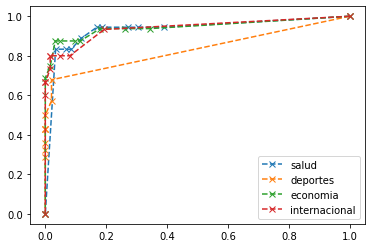

In [ ]:
results_dict = {}
class_probs = get_class_probabilities(data, 'clase')
for i,title in enumerate(test_titles):
    results_dict[title] = {}
    results_dict[title]['clase'] = test_classes[i]
    data_point = title_to_datapoint(data, 'clase', title)
    results_dict[title]['results'] = naive_bayes(class_probs, likelihood_dict_news, data_point)
for class_name in Counter(test_classes).keys():
    x = []
    y = []
    for umbral in [i*0.1 for i in range(11)]:
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0
        for data_point in results_dict.keys():
            if results_dict[data_point]['results'][class_name] > umbral:
                if results_dict[data_point]['clase'] == class_name:
                    true_positives += 1
                else:
                    false_positives += 1
            else:
                if results_dict[data_point]['clase'] == class_name:
                    false_negatives += 1
                else:
                    true_negatives += 1
        x.append(false_positives / (false_positives + true_negatives))
        y.append(true_positives / (true_positives + false_negatives))
    plt.plot(x,y,'--x')
    points = [(x[i],y[i]) for i in range(len(x))]
    points.sort()
    print(class_name + ": " + str(metrics.auc([p[0] for p in points], [p[1] for p in points])))
plt.legend(Counter(test_classes).keys())

# **Ejercicio 4**

In [ ]:
def read_data(file_name):
    f = open(file_name)
    ret = {}
    ret['rank'],ret['gre'],ret['gpa'],ret['admit'] = [],[],[],[]
    #Leo los headers
    f.readline()
    line = f.readline()
    while line != '' and line != '\n':
        data = line.split(',')
        ret['admit'].append(int(data[0]))
        ret['gre'].append(1 if int(data[1]) >= 500 else 0)
        ret['gpa'].append(1 if float(data[2]) >= 3 else 0)
        ret['rank'].append(int(data[3]))
        line = f.readline()
    f.close()
    return ret

data_set_admissions = read_data('binary.csv')

Dado el grafo del enunciado, podemos obtener una expresión para la probabilidad conjunta de una observación. La misma la calculamos con la función **get_joint_probability**. 

In [ ]:
def get_admit_given_rank_gpa_gre(admit, rank, gpa, gre):
    accum = 0
    denom = 0
    for i in range(len(data_set_admissions['gre'])):
        if data_set_admissions['rank'][i] == rank and data_set_admissions['gpa'][i] == gpa and data_set_admissions['gre'][i] == gre:
            accum += 1 if data_set_admissions['admit'][i] == admit else 0
            denom += 1
    return (accum + 1) / (denom + 2)

def get_gre_given_rank(gre, rank):
    accum = 0
    for i in range(len(data_set_admissions['gre'])):
        if data_set_admissions['rank'][i] == rank:
            accum += 1 if data_set_admissions['gre'][i] == gre else 0
    return (accum + 1) / (len(list(filter(lambda x : x == rank, data_set_admissions['rank']))) + 2)

def get_gpa_given_rank(gpa, rank):
    accum = 0
    for i in range(len(data_set_admissions['gpa'])):
        if data_set_admissions['rank'][i] == rank:
            accum += 1 if data_set_admissions['gpa'][i] == gpa else 0
    return (accum + 1) / (len(list(filter(lambda x : x == rank, data_set_admissions['rank']))) + 2)

def get_rank_probability(rank):
    return (len(list(filter(lambda x : x == rank, data_set_admissions['rank']))) + 1)/(len(data_set_admissions['rank']) + 4)

def get_joint_probability(rank, gre, gpa, admit):
    return get_rank_probability(rank) * get_gpa_given_rank(gpa, rank) * get_gre_given_rank(gre, rank) * get_admit_given_rank_gpa_gre(admit, rank, gpa, gre)

#Ejercicio a
joint_probability = 0
for gpa in [0,1]:
    for gre in [0,1]:
        joint_probability += get_joint_probability(1,gre,gpa,0)
evidence_probability = get_rank_probability(1)
print(joint_probability/evidence_probability)

#Ejercicio b
joint_probability = get_joint_probability(2, 0, 1, 1)
evidence_probability = get_joint_probability(2, 0, 1, 1) + get_joint_probability(2, 0, 1, 0)
print(joint_probability/evidence_probability)

0.43573511037067886
0.21739130434782608
